# Exploratory Data Analysis on the BindingDB dataset from JGLaser's HuggingFace Datasets repository.
By Christian Pala, Carlo Grigioni and Andrea Wey

### Importing libraries

In [100]:
from rdkit.Chem.Draw import IPythonConsole
import itertools
import numpy as np
import pandas as pd
from datasets import load_dataset
from rdkit import Chem
from rdkit.Chem import AllChem, rdDepictor
from collections import Counter
import matplotlib.pyplot as plt
import mols2grid
import seaborn as sns

# Visualization
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 300, 300
rdDepictor.SetPreferCoordGen(True)

# Set up Seaborn plot aesthetics
sns.set()
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')

### Loading the dataset

In [3]:
train_proportion = 'train[:7%]'
validation_proportion = 'train[7%:8%]'
test_proportion = 'train[8%:10%]'

In [5]:
dataset = load_dataset("jglaser/binding_affinity", split=train_proportion)

Found cached dataset binding_affinity (/home/light/.cache/huggingface/datasets/jglaser___binding_affinity/default/1.4.1/caf1a3e2b3eb66a5ee7b44fa9b039ae9188b949c6da91d8077998f347883556c)


### Exploring the dataset

Number of samples in the dataset:

In [14]:
len(dataset)

128571

In [15]:
dataset.features

{'seq': Value(dtype='string', id=None),
 'smiles': Value(dtype='string', id=None),
 'affinity_uM': Value(dtype='float32', id=None),
 'neg_log10_affinity_M': Value(dtype='float32', id=None),
 'smiles_can': Value(dtype='string', id=None),
 'affinity': Value(dtype='float32', id=None)}

The dataset has 6 features, the (canonical) smiles of the ligand, the protein sequence, the binding affinity as molar units, as negative log units and as generic affinity.

Checking for missing values:


In [22]:
train_ds = pd.DataFrame(dataset)
train_ds.isna().sum()

seq                     0
smiles                  0
affinity_uM             0
neg_log10_affinity_M    0
smiles_can              0
affinity                0
dtype: int64

In [23]:
train_ds.head()

,seq,smiles,affinity_uM,neg_log10_affinity_M,smiles_can,affinity
0,MTVPDRSEIAGKWYVVALASNTEFFLREKDKMKMAMARISFLGEDE...,CCCCCCCCCCCCCCCCCCCC(=O)O,0.026,7.585027,CCCCCCCCCCCCCCCCCCCC(=O)O,0.691712
1,APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGE...,OC[C@H]1O[C@H](Oc2cccc(c2)N(=O)=O)[C@@H]([C@H]...,500.000,3.301030,O=[N+]([O-])c1cccc(O[C@H]2O[C@H](CO)[C@H](O)[C...,-2.054668
2,VETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNSSDALDKIRYE...,COc1ccc(cc1)c1c(onc1c1cc(C(C)C)c(cc1O)O)NC(=O)...,0.023,7.638272,COc1ccc(-c2c(-c3cc(C(C)C)c(O)cc3O)noc2NC(=O)C2...,0.725847
3,AAPFDKSKNVAQSIDQLIGQTPALYLNKLNNTKAKVVLKMECENPM...,OC[C@@H](C(=O)N[C@@H]([C@H](CC)C)C(=O)O)NC(=O)...,6.430,5.191789,CC[C@H](C)[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC1...,-0.842542
4,YITFRSFTAVLIAFFLTLVLSPSFINRLRKIQRKKYTPTMGGIVIL...,CO[C@@H]1[C@H](O[C@H]([C@@H]1O)n1ccc(=O)[nH]c1...,0.185,6.732828,CO[C@@H]1[C@@H]([C@@H](O[C@H]2OC(C(=O)N[C@H]3C...,0.145386


In [24]:
train_ds.describe()

,affinity_uM,neg_log10_affinity_M,affinity
count,1.285710e+05,128571.000000,128571.000000
mean,1.838874e+02,5.659238,-0.542870
std,4.120397e+03,1.594229,1.022026
min,1.000000e-09,0.130711,-4.087092
25%,2.000000e-01,4.399670,-1.350353
50%,4.500000e+00,5.346787,-0.743176
75%,3.984100e+01,6.698970,0.123680
max,7.400971e+05,15.000000,5.445295


In [25]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128571 entries, 0 to 128570
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   seq                   128571 non-null  object 
 1   smiles                128571 non-null  object 
 2   affinity_uM           128571 non-null  float64
 3   neg_log10_affinity_M  128571 non-null  float64
 4   smiles_can            128571 non-null  object 
 5   affinity              128571 non-null  float64
dtypes: float64(3), object(3)
memory usage: 5.9+ MB


We have 128571 samples, which is a reasonable amount of data to train a model on, canonical smiles have been provided, as well as the protein sequence as a string. We have the binding affinity as a float, which has been aggregated by various datasets using different methodologies to measure it. As expected from a benchmark dataset, no real preprocessing is required.

We first analyse the protein sequences.

In [11]:
protein_sequences = dataset['seq']

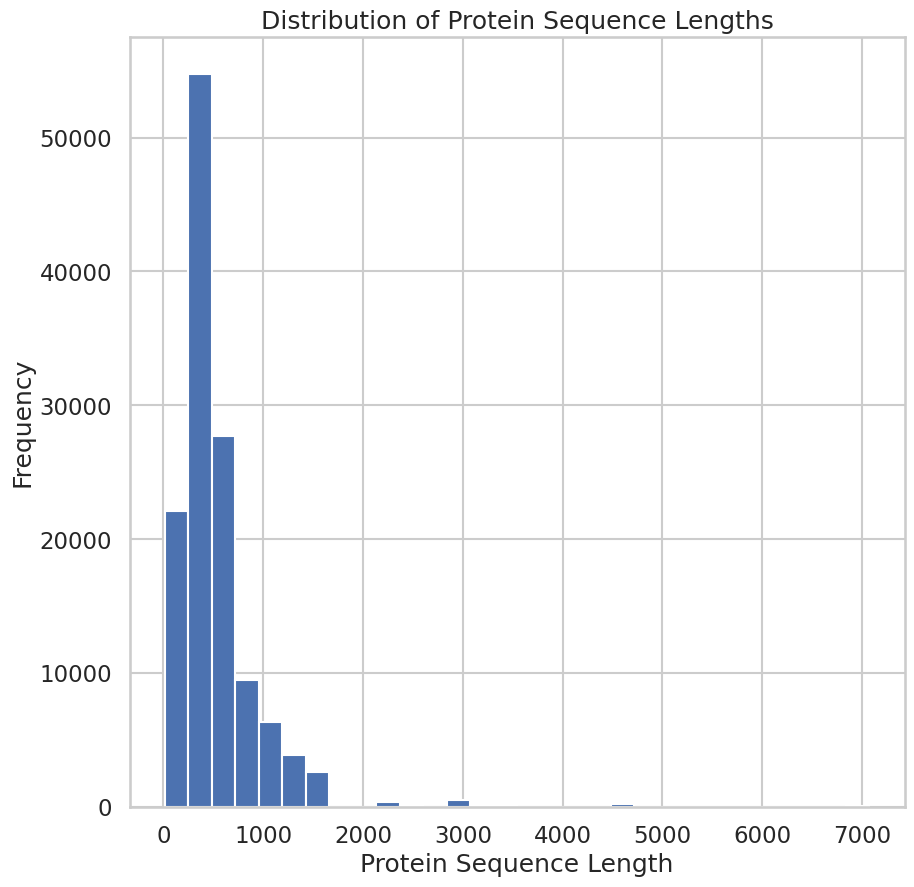

In [101]:
protein_lengths = [len(seq) for seq in protein_sequences]

plt.hist(protein_lengths, bins=30)
plt.xlabel('Protein Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Protein Sequence Lengths')
plt.show()

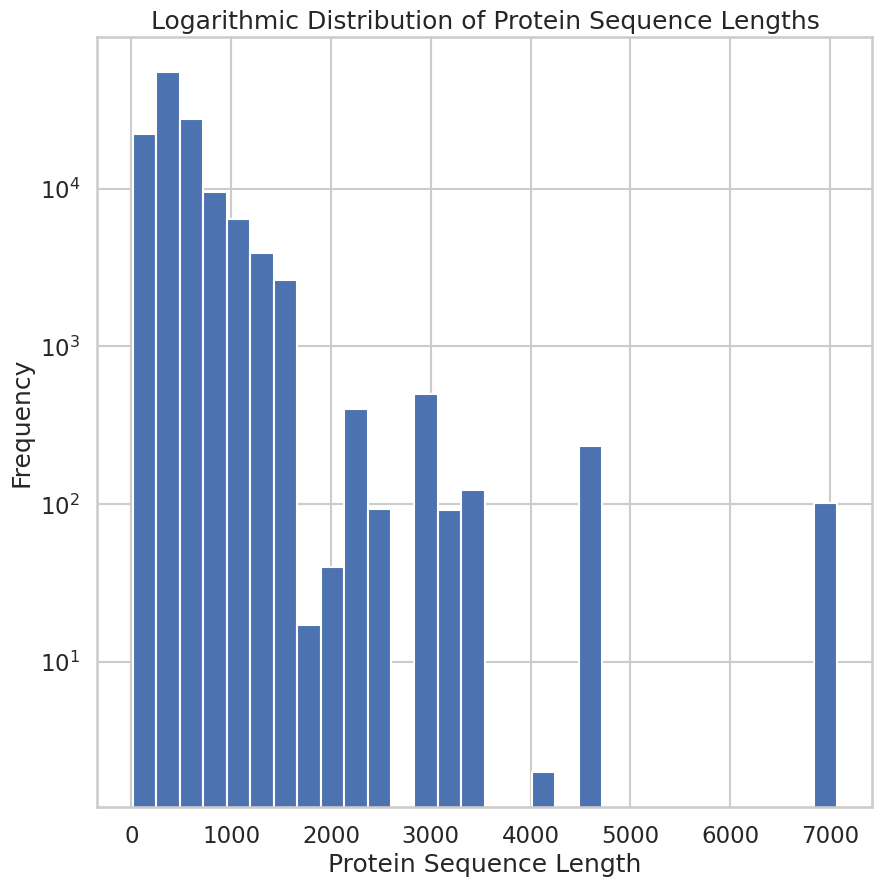

In [102]:
plt.hist(protein_lengths, bins=30, log=True)
plt.xlabel('Protein Sequence Length')
plt.ylabel('Frequency')
plt.title('Logarithmic Distribution of Protein Sequence Lengths')
plt.show()

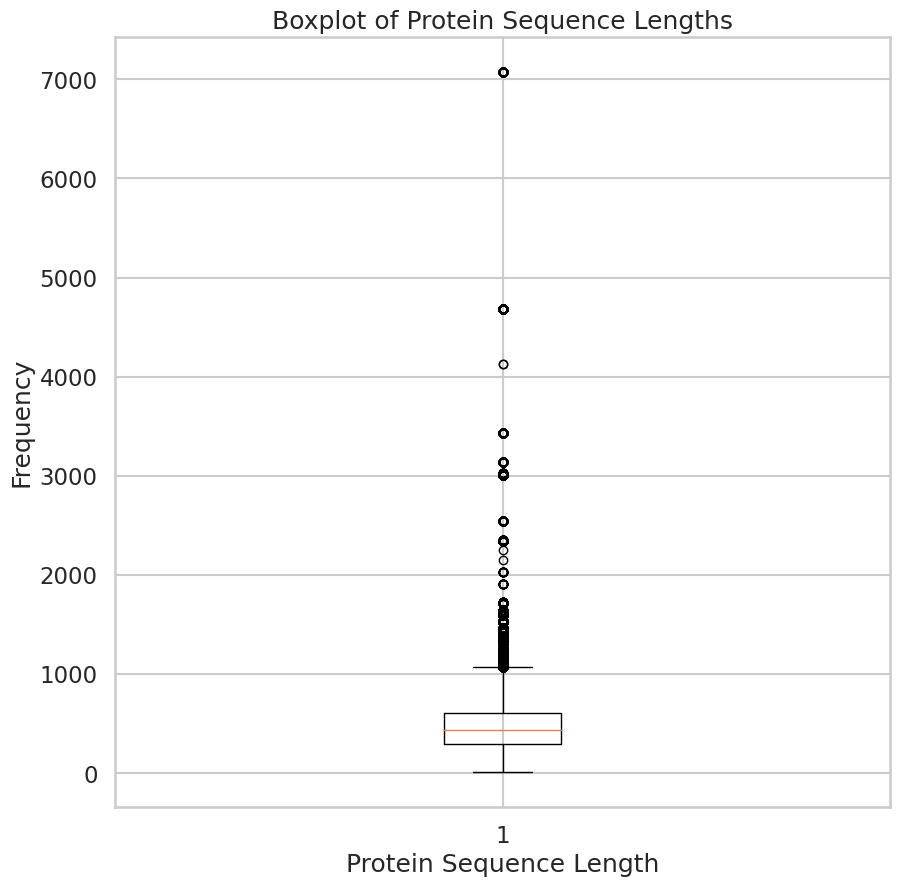

In [103]:
plt.boxplot(protein_lengths)
plt.xlabel('Protein Sequence Length')
plt.ylabel('Frequency')
plt.title('Boxplot of Protein Sequence Lengths')
plt.show()

In [30]:
pd.Series(protein_lengths).quantile([0.1, 0.25, 0.5, 0.75, 0.9])
print('10% of the protein sequences have a length smaller or equal to', np.quantile(protein_lengths, 0.1))
print('25% of the protein sequences have a length smaller or equal to', np.quantile(protein_lengths, 0.25))
print('50% of the protein sequences have a length of smaller or equal to', np.quantile(protein_lengths, 0.5))
print('75% of the protein sequences have a length of smaller or equal to', np.quantile(protein_lengths, 0.75))
print('90% of the protein sequences have a length of smaller or equal to', np.quantile(protein_lengths, 0.9))

10% of the protein sequences have a length smaller or equal to 193.0
25% of the protein sequences have a length smaller or equal to 293.0
50% of the protein sequences have a length of smaller or equal to 440.0
75% of the protein sequences have a length of smaller or equal to 605.0
90% of the protein sequences have a length of smaller or equal to 1032.0


In [34]:
print(f"The average protein length is: {np.mean(protein_lengths):.3f}")

The average protein length is: 535.101


### Check the amino acid distribution

Ensure all protein sequences are uppercase

In [38]:
protein_sequences = [seq.upper() for seq in protein_sequences]

In [39]:
amino_acids = Counter(itertools.chain.from_iterable(protein_sequences))

Text(0.5, 1.0, 'Distribution of Amino Acids')

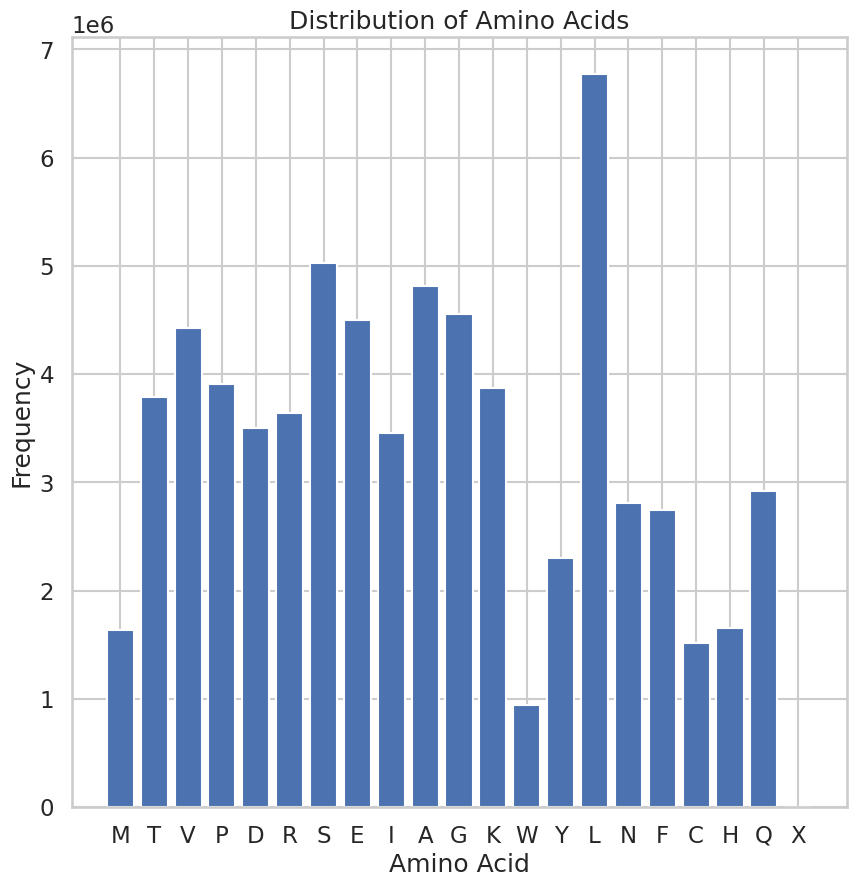

In [104]:
# Plot the distribution of amino acids
plt.bar(amino_acids.keys(), amino_acids.values())
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.title('Distribution of Amino Acids')

Leucine, which is aliphatic, is the most prevalent amino acid in our training dataset. Interestingly we also have X as a placeholder for unknown amino acids.

We have a reasonably diverse amount of proteins and amino acids, with some noticeable protein outliers of lengths 2000 and over.

### Exploring the ligands

In [41]:
ligands = dataset['smiles']

In [42]:
ligand_lengths = [len(ligand) for ligand in ligands]

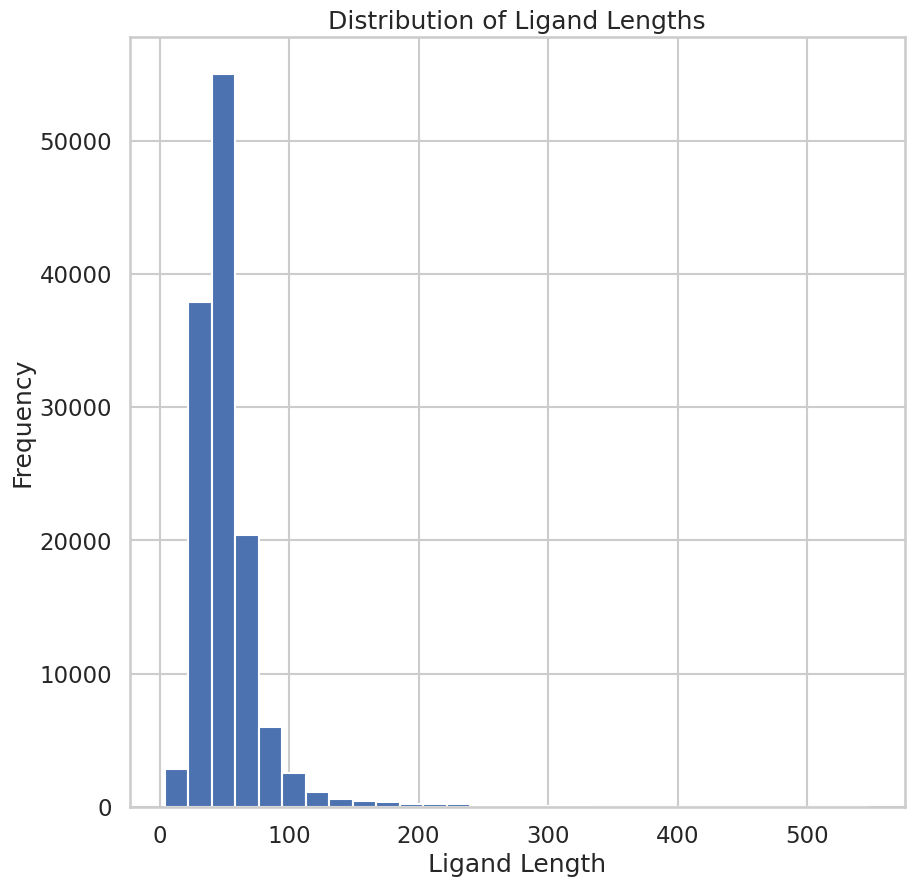

In [105]:
plt.hist(ligand_lengths, bins=30)
plt.xlabel('Ligand Length')
plt.ylabel('Frequency')
plt.title('Distribution of Ligand Lengths')
plt.show()

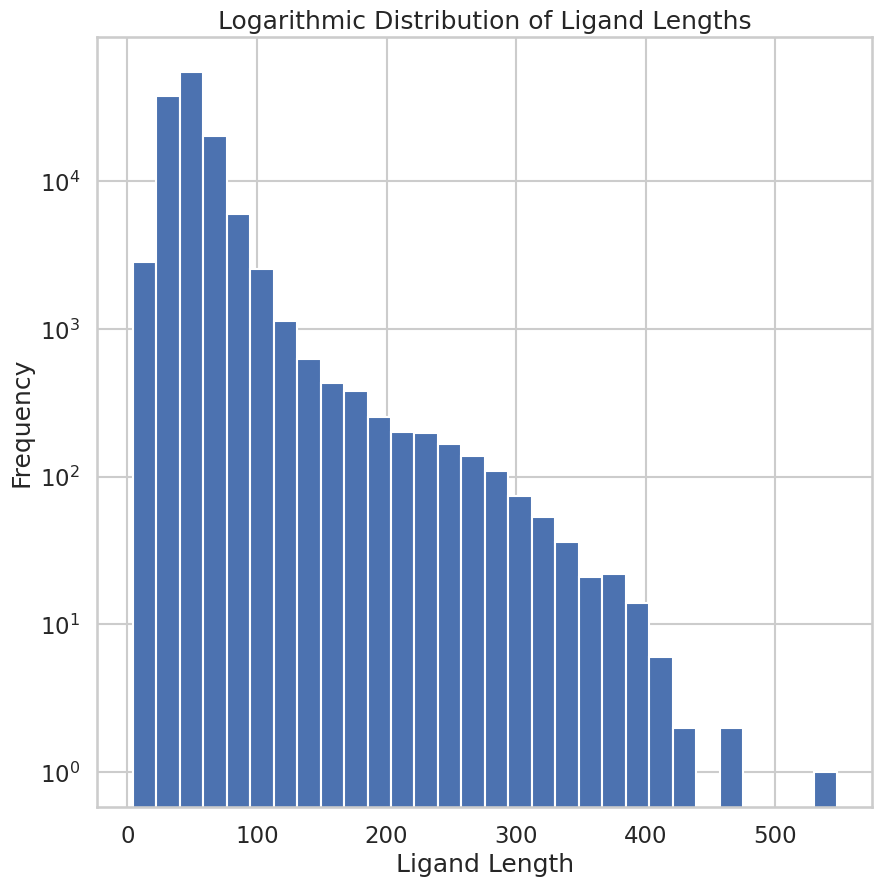

In [106]:
plt.hist(ligand_lengths, bins=30, log=True)
plt.xlabel('Ligand Length')
plt.ylabel('Frequency')
plt.title('Logarithmic Distribution of Ligand Lengths')
plt.show()

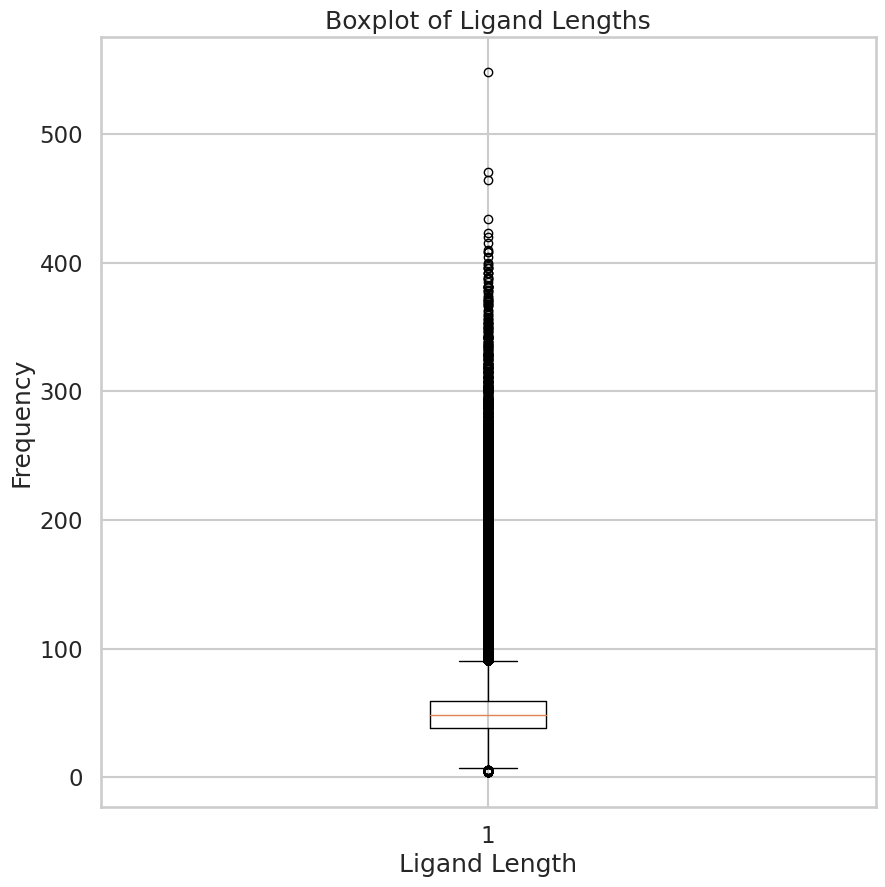

In [107]:
plt.boxplot(ligand_lengths)
plt.xlabel('Ligand Length')
plt.ylabel('Frequency')
plt.title('Boxplot of Ligand Lengths')
plt.show()

In [46]:
pd.Series(ligand_lengths).quantile([0.1, 0.25, 0.5, 0.75, 0.9])
print('10% of the ligands have a length smaller or equal to', np.quantile(ligand_lengths, 0.1))
print('25% of the ligands have a length smaller or equal to', np.quantile(ligand_lengths, 0.25))
print('50% of the ligands have a length of smaller or equal to', np.quantile(ligand_lengths, 0.5))
print('75% of the ligands have a length of smaller or equal to', np.quantile(ligand_lengths, 0.75))
print('90% of the ligands have a length of smaller or equal to', np.quantile(ligand_lengths, 0.9))

10% of the ligands have a length smaller or equal to 31.0
25% of the ligands have a length smaller or equal to 38.0
50% of the ligands have a length of smaller or equal to 48.0
75% of the ligands have a length of smaller or equal to 59.0
90% of the ligands have a length of smaller or equal to 76.0


In [47]:
print(f"The average ligand length is: {np.mean(ligand_lengths):.3f}")

The average ligand length is: 52.961


In [49]:
train_ds['romol'] = train_ds['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [109]:
portion = 50
mols2grid.display(train_ds['romol'][:portion], legends=list(train_ds['affinity']))

MolGridWidget()

### Molecular Descriptors

In [53]:
train_ds['mol_weight'] = train_ds['romol'].apply(lambda x: Chem.rdMolDescriptors.CalcExactMolWt(x))

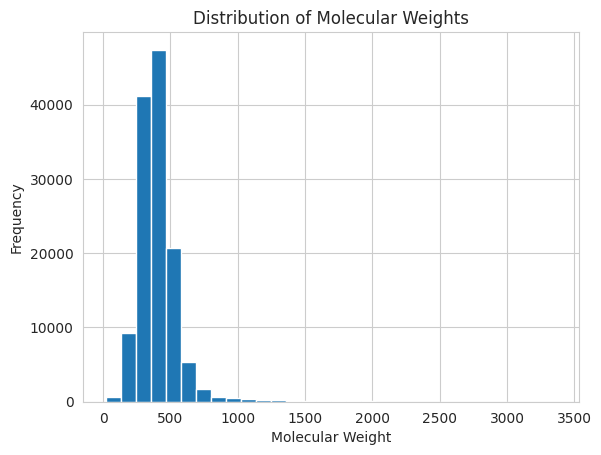

In [56]:
plt.hist(train_ds['mol_weight'], bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Molecular Weights')
plt.show()

### Clustering with morgan fingerprints

In [76]:
train_ds['morgan_fp'] = train_ds['romol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))

We use TruncatedSVD dimensionality reduction for efficiency and memory management, due to the large dataset.

In [93]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
train_ds['morgan_fp_svd'] = list(svd.fit_transform(list(train_ds['morgan_fp'])))

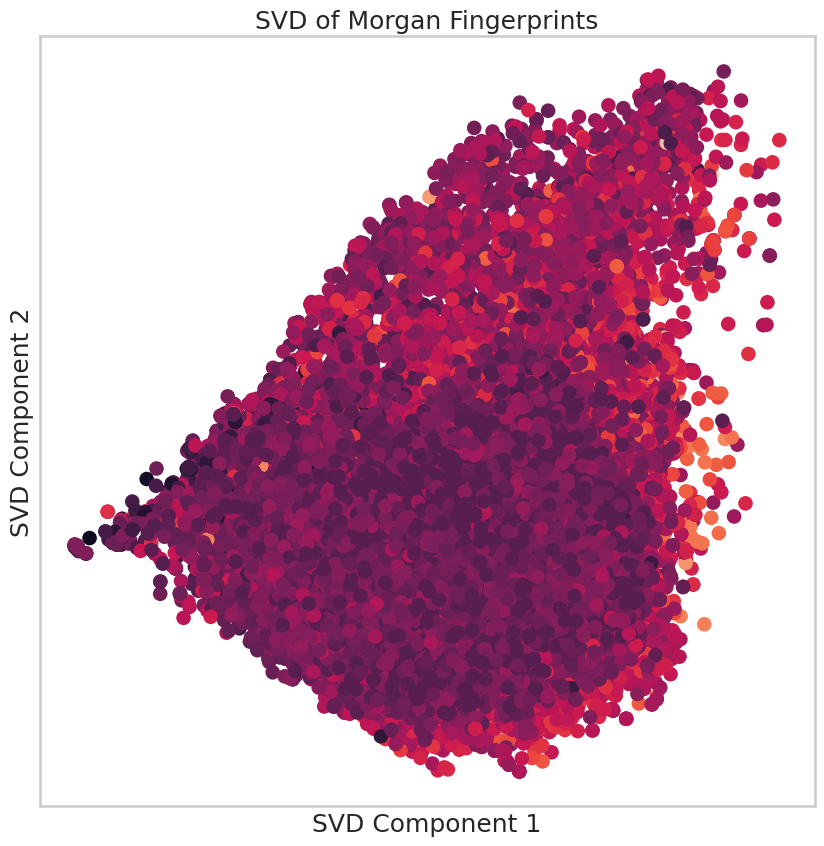

In [110]:
plt.scatter(train_ds['morgan_fp_svd'].apply(lambda x: x[0]), train_ds['morgan_fp_svd'].apply(lambda x: x[1]), c=train_ds['affinity'])
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('SVD of Morgan Fingerprints')
# remove the ticks
plt.xticks([])
plt.yticks([])
plt.show()

Looks nice but not very informative, it's clear the dataset is not easily separable.

### Affinity exploration

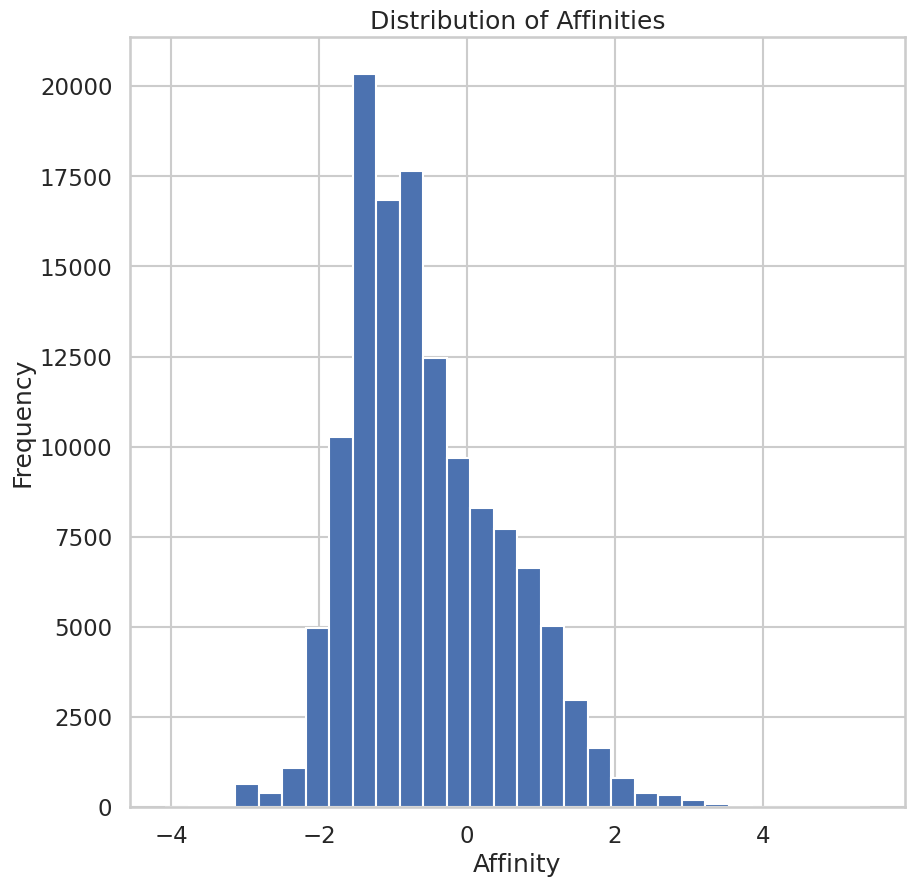

In [111]:
plt.hist(train_ds['affinity'], bins=30)
plt.xlabel('Affinity')
plt.ylabel('Frequency')
plt.title('Distribution of Affinities')
plt.show()

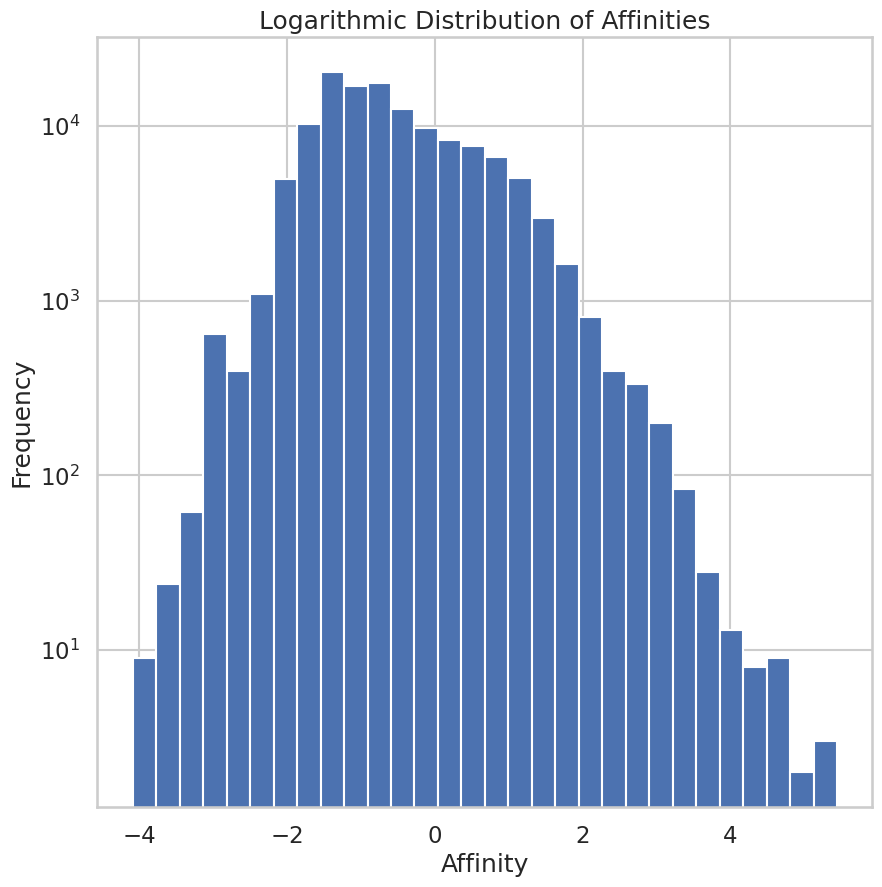

In [112]:
plt.hist(train_ds['affinity'], bins=30, log=True)
plt.xlabel('Affinity')
plt.ylabel('Frequency')
plt.title('Logarithmic Distribution of Affinities')
plt.show()

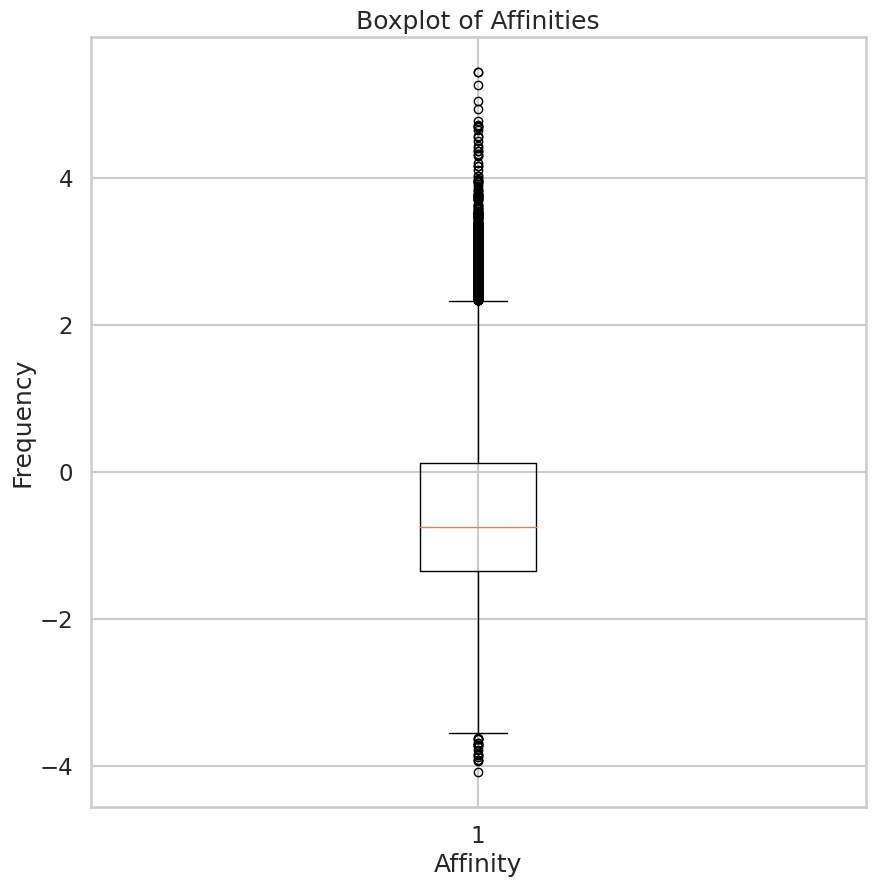

In [113]:
plt.boxplot(train_ds['affinity'])
plt.xlabel('Affinity')
plt.ylabel('Frequency')
plt.title('Boxplot of Affinities')
plt.show()

In [84]:
pd.Series(train_ds['affinity']).quantile([0.1, 0.25, 0.5, 0.75, 0.9])
print('10% of the affinities are smaller or equal to', np.quantile(train_ds['affinity'], 0.1))
print('25% of the affinities are smaller or equal to', np.quantile(train_ds['affinity'], 0.25))
print('50% of the affinities are smaller or equal to', np.quantile(train_ds['affinity'], 0.5))
print('75% of the affinities are smaller or equal to', np.quantile(train_ds['affinity'], 0.75))
print('90% of the affinities are smaller or equal to', np.quantile(train_ds['affinity'], 0.9))

10% of the affinities are smaller or equal to -1.6331087350845337
25% of the affinities are smaller or equal to -1.3503528833389282
50% of the affinities are smaller or equal to -0.743175745010376
75% of the affinities are smaller or equal to 0.12367992848157883
90% of the affinities are smaller or equal to 0.9312068223953247


In [85]:
print(f"The average affinity is: {np.mean(train_ds['affinity']):.3f}")

The average affinity is: -0.543


The distribution is very smooth, preprocessing has been done on the affinity a priori. Since this is a benchmark dataset, we will assume that the data is clean and ready to use.

### Exploring the protein-ligand interactions

In [87]:
train_ds['protein_ligand'] = train_ds['seq'] + '_' + train_ds['smiles_can']
print(f"Number of unique protein-ligand pairs: {train_ds['protein_ligand'].nunique()}")

Number of unique protein-ligand pairs: 119563


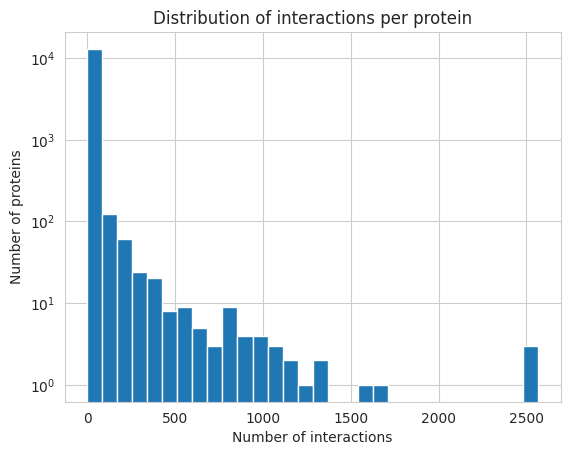

In [89]:
train_ds['seq'].value_counts().hist(bins=30, log=True)
plt.xlabel('Number of interactions')
plt.ylabel('Number of proteins')
plt.title('Distribution of interactions per protein')
plt.show()

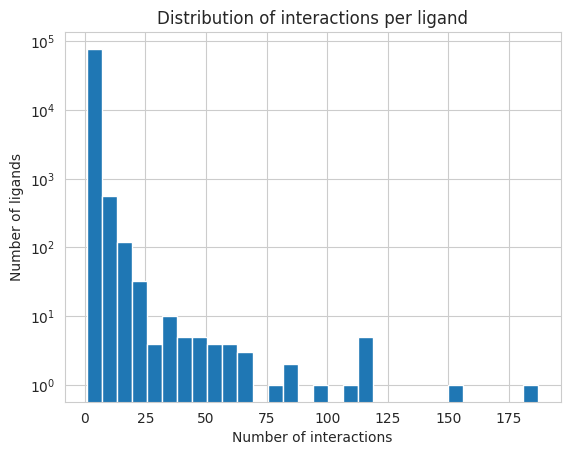

In [90]:
train_ds['smiles_can'].value_counts().hist(bins=30, log=True)
plt.xlabel('Number of interactions')
plt.ylabel('Number of ligands')
plt.title('Distribution of interactions per ligand')
plt.show()

Although the dataset is fairly large, the interactions are quite sparse, with most proteins having less than 1000 interactions and most ligands having less than 100 interactions, this will make it difficult to train a model that can generalize well.

## Conclusion

This is a challenging task, the dataset seems large but looking at the interactions it's not a given that we will be able to train complex models, especially with the limited resources we have at hand.

We will try our best ;-).